In [2]:
### import the necessary library
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("Cleaned_Merged_Data.csv")

In [3]:
# step 1 :we need to make sure diagnosis_date is in the right format for time-based analysis -we are workinh on new notebook and reoccurent code can gte back to orginal type string.
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'], errors='coerce')
df['year'] = df['diagnosis_date'].dt.year

In [4]:
##Step 2: Create a chronic condition flag
# We'll mark patients who have been diagnosed with chronic illnesses
# These are the patients who already cost more — we want to learn what they look like

df['chronic_flag'] = df['diagnosis'].isin(['Diabetes Type 2', 'Hypertension', 'Asthma'])

In [5]:
## Step 3: Compare biometrics in chronic vs non-chronic patients
##Let’s look at how BMI, BP, and cholesterol differ between chronic and non-chronic groups
df.groupby('chronic_flag')[['bmi', 'blood_pressure_systolic', 'cholesterol_total']].mean()

,bmi,blood_pressure_systolic,cholesterol_total
chronic_flag,,,
False,24.629019,118.741406,199.970101
True,25.773691,121.231798,199.822835


### If chronic patients consistently have higher BMI or cholesterol, those features can be used to flag future risk.

In [6]:
## Step 4: Identify undiagnosed but high-risk patients
# Now we isolate patients who don’t have any diagnosis recorded
# Among them, we look for high-risk biometric values (e.g., BMI > 30, high cholesterol)

undiagnosed = df[df['diagnosis'].isnull()]
high_risk = undiagnosed[(undiagnosed['bmi'] > 30) | (undiagnosed['cholesterol_total'] > 220)]

# Preview a few high-risk, undiagnosed patients
high_risk[['patient_id', 'bmi', 'cholesterol_total', 'age', 'gender', 'visit_type']].head()

,patient_id,bmi,cholesterol_total,age,gender,visit_type
35,PAT00020,22.812643,244.0,27.0,Male,NaN
66,PAT00040,33.365915,210.0,71.0,Male,NaN
67,PAT00041,18.566764,232.0,37.0,Male,NaN
69,PAT00043,15.895684,226.0,49.0,Male,NaN
228,PAT00135,25.844035,225.0,65.0,Female,NaN


### These are the patients who haven’t been diagnosed yet, but their vitals suggest they’re on that path — a perfect target for pharmacy or digital check-ins.

In [7]:
## Step 5: Stratify all patients by risk level
# We’ll assign a simple risk group label based on combinations of biometric indicators
# These aren’t clinical grades — just a starting point for targeting

df['risk_group'] = 'Low'
df.loc[(df['bmi'] > 30) & (df['cholesterol_total'] > 220), 'risk_group'] = 'High'
df.loc[((df['bmi'] > 27) | (df['cholesterol_total'] > 200)) & (df['risk_group'] != 'High'), 'risk_group'] = 'Moderate'

# See how many patients fall into each risk group
df['risk_group'].value_counts()

risk_group
Low         17094
Moderate    15137
High          915
Name: count, dtype: int64

##  This gives Loblaw a way to prioritize who might benefit from proactive care — and it’s simple enough to act on quickly.

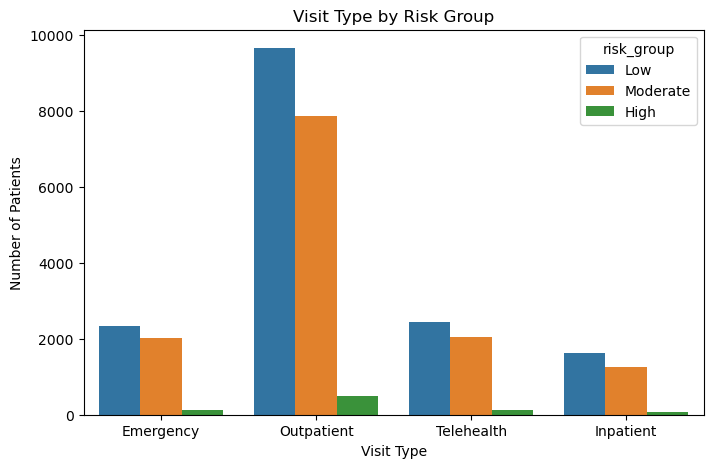

In [8]:
##  Visualize risk profile by care type
import seaborn as sns
import matplotlib.pyplot as plt

# Let’s see where each risk group is showing up — ER, Telehealth, Outpatient
plt.figure(figsize=(8, 5))
sns.countplot(x='visit_type', hue='risk_group', data=df)
plt.title("Visit Type by Risk Group")
plt.ylabel("Number of Patients")
plt.xlabel("Visit Type")
plt.show()

 ## Outpatient visits dominate — especially among Low and Moderate risk patients.
These are likely routine or manageable visits. No surprise there.

## Emergency visits still have a strong Moderate + High risk presence
While Low-risk patients also go to the ER, seeing High-risk patients showing up there is a red flag

These are patients we likely could have caught earlier and redirected.

### Telehealth is used across all risk groups, but usage is still lower than outpatient, especially among high-risk groups.
This suggests an opportunity to increase digital engagement with higher-risk patients through the PC Health app.

### Inpatient visits are fairly even but still skew toward Moderate and Low.
Not a major focus here, but still important to track for escalations.